Convolutional Neural Network (CNN) implementation for Diabetic Retinopathy Detection 
https://www.kaggle.com/c/diabetic-retinopathy-detection/data

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras 

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from cv2 import cv2
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt

from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.utils import plot_model
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from numpy import array 

In [3]:
#import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

I have already downloaded the dataset from Kaggle.
I have noted all the steps to download the database in a seperate file.
Below I am loading a CSV file containing training labels 

In [4]:
df_train = pd.read_csv('/storage/trainLabels.csv')

Lets take a look at all the labels.
'10_left' is a name of the file whereas '0/1/2/3/4' are the labels
'10_left' image of the left eye
'10_right' image of the right eye for the same person

In [5]:
df_train.values

array([['10_left', 0],
       ['10_right', 0],
       ['13_left', 0],
       ...,
       ['44348_right', 0],
       ['44349_left', 0],
       ['44349_right', 1]], dtype=object)

There are 35125 images in the training set, 'level' is the column indicating the labels for its respective images

In [6]:
df_train.tail()

,image,level
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0
35125,44349_right,1


We will use Pandas to convert df_train into a series.
and get_dummies to do one hot encoding (FYI, I am not using one hot encoding during training as of now)

In [7]:
targets_series = pd.Series(df_train['level'])
one_hot = pd.get_dummies(targets_series, sparse = True)

As I said before there are 5 types of labels 0/1/2/3/4, thry are distinguished as below
NDPR - Non Proliferative Diabetic Retinopathy

Class	 Name
0	    Normal	
1	    Mild NPDR
2	    Moderate NPDR
3	    Severe NPDR	
4	    PDR

In [8]:
targets_series[:10]

0    0
1    0
2    0
3    0
4    1
5    2
6    4
7    4
8    0
9    1
Name: level, dtype: int64

In [9]:
one_hot[:10]

,0,1,2,3,4
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0
5,0,0,1,0,0
6,0,0,0,0,1
7,0,0,0,0,1
8,1,0,0,0,0
9,0,1,0,0,0


In [10]:
one_hot_labels = np.asarray(one_hot)

In [11]:
one_hot_labelsY = np.asarray(targets_series)

Lets take a look at the array containing just the labels

In [12]:
one_hot_labelsY[:10]

array([0, 0, 0, 0, 1, 2, 4, 4, 0, 1])

Some declarations

In [13]:
im_size1 = 786
im_size2 = 786

In [14]:
x_train = []
y_train = []

If you are interested to check all image names

In [15]:
i = 0 
for f, breed in tqdm(df_train.values):
    print(f)


  8%|▊         | 2939/35126 [00:00<00:02, 13231.53it/s]

10_left
10_right
13_left
13_right
15_left
15_right
16_left
16_right
17_left
17_right
19_left
19_right
20_left
20_right
21_left
21_right
22_left
22_right
23_left
23_right
25_left
25_right
30_left
30_right
31_left
31_right
33_left
33_right
36_left
36_right
40_left
40_right
41_left
41_right
42_left
42_right
46_left
46_right
47_left
47_right
49_left
49_right
51_left
51_right
52_left
52_right
54_left
54_right
56_left
56_right
57_left
57_right
58_left
58_right
59_left
59_right
60_left
60_right
62_left
62_right
64_left
64_right
65_left
65_right
66_left
66_right
67_left
67_right
70_left
70_right
72_left
72_right
73_left
73_right
74_left
74_right
75_left
75_right
78_left
78_right
79_left
79_right
81_left
81_right
82_left
82_right
84_left
84_right
95_left
95_right
99_left
99_right
100_left
100_right
102_left
102_right
104_left
104_right
108_left
108_right
111_left
111_right
114_left
114_right
115_left
115_right
117_left
117_right
119_left
119_right
122_left
122_right
125_left
125_right
129_left


 14%|█▍        | 4888/35126 [00:00<00:02, 13946.63it/s]

3641_right
3643_left
3643_right
3646_left
3646_right
3648_left
3648_right
3650_left
3650_right
3651_left
3651_right
3652_left
3652_right
3653_left
3653_right
3654_left
3654_right
3655_left
3655_right
3657_left
3657_right
3660_left
3660_right
3661_left
3661_right
3662_left
3662_right
3671_left
3671_right
3673_left
3673_right
3677_left
3677_right
3682_left
3682_right
3687_left
3687_right
3688_left
3688_right
3692_left
3692_right
3693_left
3693_right
3695_left
3695_right
3697_left
3697_right
3698_left
3698_right
3699_left
3699_right
3700_left
3700_right
3703_left
3703_right
3706_left
3706_right
3708_left
3708_right
3710_left
3710_right
3712_left
3712_right
3721_left
3721_right
3722_left
3722_right
3723_left
3723_right
3726_left
3726_right
3727_left
3727_right
3738_left
3738_right
3740_left
3740_right
3741_left
3741_right
3742_left
3742_right
3743_left
3743_right
3744_left
3744_right
3748_left
3748_right
3749_left
3749_right
3750_left
3750_right
3752_left
3752_right
3754_left
3754_right
37

 24%|██▍       | 8384/35126 [00:00<00:01, 15166.97it/s]

8015_left
8015_right
8020_left
8020_right
8023_left
8023_right
8025_left
8025_right
8026_left
8026_right
8027_left
8027_right
8028_left
8028_right
8029_left
8029_right
8030_left
8030_right
8032_left
8032_right
8034_left
8034_right
8036_left
8036_right
8038_left
8038_right
8039_left
8039_right
8040_left
8040_right
8041_left
8041_right
8043_left
8043_right
8047_left
8047_right
8050_left
8050_right
8052_left
8052_right
8059_left
8059_right
8061_left
8061_right
8062_left
8062_right
8067_left
8067_right
8072_left
8072_right
8073_left
8073_right
8074_left
8074_right
8080_left
8080_right
8087_left
8087_right
8089_left
8089_right
8090_left
8090_right
8091_left
8091_right
8092_left
8092_right
8093_left
8093_right
8096_left
8096_right
8105_left
8105_right
8107_left
8107_right
8110_left
8110_right
8111_left
8111_right
8113_left
8113_right
8114_left
8114_right
8115_left
8115_right
8116_left
8116_right
8121_left
8121_right
8122_left
8122_right
8123_left
8123_right
8126_left
8126_right
8129_left
812

 33%|███▎      | 11675/35126 [00:00<00:01, 15529.80it/s]

12511_right
12513_left
12513_right
12514_left
12514_right
12515_left
12515_right
12519_left
12519_right
12521_left
12521_right
12523_left
12523_right
12525_left
12525_right
12527_left
12527_right
12533_left
12533_right
12536_left
12536_right
12539_left
12539_right
12546_left
12546_right
12547_left
12547_right
12553_left
12553_right
12554_left
12554_right
12560_left
12560_right
12561_left
12561_right
12563_left
12563_right
12565_left
12565_right
12567_left
12567_right
12568_left
12568_right
12573_left
12573_right
12575_left
12575_right
12577_left
12577_right
12581_left
12581_right
12586_left
12586_right
12587_left
12587_right
12589_left
12589_right
12590_left
12590_right
12591_left
12591_right
12595_left
12595_right
12596_left
12596_right
12597_left
12597_right
12602_left
12602_right
12604_left
12604_right
12606_left
12606_right
12608_left
12608_right
12612_left
12612_right
12614_left
12614_right
12616_left
12616_right
12618_left
12618_right
12620_left
12620_right
12623_left
12623_right

 42%|████▏     | 14875/35126 [00:00<00:01, 14993.37it/s]


15595_left
15595_right
15596_left
15596_right
15599_left
15599_right
15602_left
15602_right
15603_left
15603_right
15605_left
15605_right
15610_left
15610_right
15611_left
15611_right
15612_left
15612_right
15615_left
15615_right
15625_left
15625_right
15627_left
15627_right
15630_left
15630_right
15631_left
15631_right
15635_left
15635_right
15636_left
15636_right
15638_left
15638_right
15639_left
15639_right
15640_left
15640_right
15641_left
15641_right
15643_left
15643_right
15644_left
15644_right
15645_left
15645_right
15646_left
15646_right
15652_left
15652_right
15653_left
15653_right
15655_left
15655_right
15656_left
15656_right
15657_left
15657_right
15658_left
15658_right
15660_left
15660_right
15661_left
15661_right
15666_left
15666_right
15667_left
15667_right
15674_left
15674_right
15682_left
15682_right
15683_left
15683_right
15688_left
15688_right
15690_left
15690_right
15692_left
15692_right
15694_left
15694_right
15695_left
15695_right
15696_left
15696_right
15698_left

 54%|█████▎    | 18870/35126 [00:01<00:00, 16354.21it/s]


20510_right
20513_left
20513_right
20515_left
20515_right
20517_left
20517_right
20522_left
20522_right
20523_left
20523_right
20525_left
20525_right
20529_left
20529_right
20533_left
20533_right
20534_left
20534_right
20535_left
20535_right
20539_left
20539_right
20540_left
20540_right
20541_left
20541_right
20544_left
20544_right
20546_left
20546_right
20547_left
20547_right
20549_left
20549_right
20550_left
20550_right
20554_left
20554_right
20555_left
20555_right
20556_left
20556_right
20567_left
20567_right
20568_left
20568_right
20569_left
20569_right
20570_left
20570_right
20573_left
20573_right
20574_left
20574_right
20578_left
20578_right
20583_left
20583_right
20590_left
20590_right
20591_left
20591_right
20592_left
20592_right
20596_left
20596_right
20599_left
20599_right
20603_left
20603_right
20605_left
20605_right
20608_left
20608_right
20611_left
20611_right
20612_left
20612_right
20613_left
20613_right
20616_left
20616_right
20617_left
20617_right
20621_left
20621_righ

 64%|██████▎   | 22366/35126 [00:01<00:00, 16550.43it/s]

25338_right
25345_left
25345_right
25346_left
25346_right
25351_left
25351_right
25352_left
25352_right
25354_left
25354_right
25357_left
25357_right
25360_left
25360_right
25361_left
25361_right
25364_left
25364_right
25374_left
25374_right
25377_left
25377_right
25378_left
25378_right
25379_left
25379_right
25382_left
25382_right
25385_left
25385_right
25389_left
25389_right
25390_left
25390_right
25392_left
25392_right
25395_left
25395_right
25396_left
25396_right
25399_left
25399_right
25401_left
25401_right
25402_left
25402_right
25404_left
25404_right
25407_left
25407_right
25408_left
25408_right
25412_left
25412_right
25413_left
25413_right
25417_left
25417_right
25419_left
25419_right
25420_left
25420_right
25425_left
25425_right
25426_left
25426_right
25427_left
25427_right
25428_left
25428_right
25429_left
25429_right
25435_left
25435_right
25436_left
25436_right
25438_left
25438_right
25444_left
25444_right
25445_left
25445_right
25448_left
25448_right
25449_left
25449_right

 75%|███████▌  | 26361/35126 [00:01<00:00, 17071.15it/s]


29560_left
29560_right
29562_left
29562_right
29565_left
29565_right
29569_left
29569_right
29572_left
29572_right
29574_left
29574_right
29577_left
29577_right
29579_left
29579_right
29588_left
29588_right
29589_left
29589_right
29592_left
29592_right
29594_left
29594_right
29595_left
29595_right
29596_left
29596_right
29599_left
29599_right
29601_left
29601_right
29603_left
29603_right
29604_left
29604_right
29605_left
29605_right
29608_left
29608_right
29611_left
29611_right
29612_left
29612_right
29615_left
29615_right
29618_left
29618_right
29619_left
29619_right
29620_left
29620_right
29621_left
29621_right
29622_left
29622_right
29623_left
29623_right
29625_left
29625_right
29627_left
29627_right
29628_left
29628_right
29629_left
29629_right
29632_left
29632_right
29636_left
29636_right
29638_left
29638_right
29639_left
29639_right
29640_left
29640_right
29642_left
29642_right
29645_left
29645_right
29646_left
29646_right
29647_left
29647_right
29648_left
29648_right
29650_left

 80%|███████▉  | 28071/35126 [00:01<00:00, 14524.82it/s]

33990_right
33991_left
33991_right
33995_left
33995_right
33996_left
33996_right
34003_left
34003_right
34004_left
34004_right
34006_left
34006_right
34008_left
34008_right
34011_left
34011_right
34012_left
34012_right
34013_left
34013_right
34021_left
34021_right
34022_left
34022_right
34023_left
34023_right
34024_left
34024_right
34026_left
34026_right
34027_left
34027_right
34029_left
34029_right
34032_left
34032_right
34035_left
34035_right
34038_left
34038_right
34041_left
34041_right
34043_left
34043_right
34046_left
34046_right
34049_left
34049_right
34050_left
34050_right
34052_left
34052_right
34057_left
34057_right
34058_left
34058_right
34061_left
34061_right
34063_left
34063_right
34066_left
34066_right
34069_left
34069_right
34072_left
34072_right
34075_left
34075_right
34078_left
34078_right
34084_left
34084_right
34090_left
34090_right
34095_left
34095_right
34096_left
34096_right
34097_left
34097_right
34098_left
34098_right
34099_left
34099_right
34101_left
34101_right

 91%|█████████ | 31816/35126 [00:02<00:00, 14210.18it/s]


37759_right
37760_left
37760_right
37761_left
37761_right
37762_left
37762_right
37763_left
37763_right
37769_left
37769_right
37770_left
37770_right
37771_left
37771_right
37773_left
37773_right
37776_left
37776_right
37777_left
37777_right
37782_left
37782_right
37783_left
37783_right
37784_left
37784_right
37785_left
37785_right
37788_left
37788_right
37790_left
37790_right
37792_left
37792_right
37795_left
37795_right
37802_left
37802_right
37808_left
37808_right
37811_left
37811_right
37813_left
37813_right
37818_left
37818_right
37819_left
37819_right
37821_left
37821_right
37824_left
37824_right
37827_left
37827_right
37829_left
37829_right
37831_left
37831_right
37833_left
37833_right
37834_left
37834_right
37835_left
37835_right
37836_left
37836_right
37837_left
37837_right
37839_left
37839_right
37846_left
37846_right
37848_left
37848_right
37849_left
37849_right
37851_left
37851_right
37854_left
37854_right
37856_left
37856_right
37859_left
37859_right
37865_left
37865_righ

 99%|█████████▉| 34770/35126 [00:02<00:00, 13142.90it/s]


41006_left
41006_right
41011_left
41011_right
41012_left
41012_right
41013_left
41013_right
41015_left
41015_right
41016_left
41016_right
41020_left
41020_right
41021_left
41021_right
41028_left
41028_right
41031_left
41031_right
41032_left
41032_right
41033_left
41033_right
41035_left
41035_right
41039_left
41039_right
41040_left
41040_right
41041_left
41041_right
41046_left
41046_right
41048_left
41048_right
41055_left
41055_right
41057_left
41057_right
41059_left
41059_right
41060_left
41060_right
41064_left
41064_right
41065_left
41065_right
41067_left
41067_right
41072_left
41072_right
41073_left
41073_right
41074_left
41074_right
41075_left
41075_right
41076_left
41076_right
41078_left
41078_right
41079_left
41079_right
41080_left
41080_right
41081_left
41081_right
41084_left
41084_right
41085_left
41085_right
41090_left
41090_right
41094_left
41094_right
41095_left
41095_right
41098_left
41098_right
41103_left
41103_right
41105_left
41105_right
41108_left
41108_right
41109_left

100%|██████████| 35126/35126 [00:02<00:00, 15301.70it/s]


44023_right
44025_left
44025_right
44027_left
44027_right
44029_left
44029_right
44030_left
44030_right
44032_left
44032_right
44036_left
44036_right
44042_left
44042_right
44050_left
44050_right
44053_left
44053_right
44056_left
44056_right
44059_left
44059_right
44062_left
44062_right
44064_left
44064_right
44065_left
44065_right
44066_left
44066_right
44068_left
44068_right
44069_left
44069_right
44070_left
44070_right
44073_left
44073_right
44076_left
44076_right
44079_left
44079_right
44081_left
44081_right
44083_left
44083_right
44084_left
44084_right
44086_left
44086_right
44088_left
44088_right
44091_left
44091_right
44092_left
44092_right
44093_left
44093_right
44095_left
44095_right
44096_left
44096_right
44097_left
44097_right
44099_left
44099_right
44100_left
44100_right
44103_left
44103_right
44107_left
44107_right
44113_left
44113_right
44114_left
44114_right
44115_left
44115_right
44117_left
44117_right
44118_left
44118_right
44122_left
44122_right
44123_left
44123_righ

I am creating a sub set of 1000 images out of total 35125 images

In [17]:
df_test = []

In [18]:
df_test = df_train[:20000]

IF you plan to run this code on all 35125 images then replace df_test with df_train.
This code sneppet will load all the images and labels into a numpy array.
You can also load images using OpenCV, I will mention the code OpenCV code in comments

"""
i = 0 
for f, breed in tqdm(df_train.values):
    if type(cv2.imread('/storage/train/{}.jpeg'.format(f)))==type(None):
        continue
    else:
        img = cv2.imread('/storage/train/{}.jpeg'.format(f))
        label = one_hot_labels[i]
        x_train.append(cv2.resize(img, (im_size1, im_size2)))
        y_train.append(label)
        i += 1
np.save('x_train2',x_train)
np.save('y_train2',y_train)
print('Done')
"""

In [19]:
i=0
for f, breed in tqdm(df_test.values):
    try:
        img = image.load_img(('/storage/train/{}.jpeg'.format(f)), target_size=(128, 128))
        arr = image.img_to_array(img)
        label = one_hot_labelsY[i]
        x_train.append(arr)
        y_train.append(label)
        i += 1 
    except:
        pass

100%|██████████| 20000/20000 [1:52:24<00:00,  1.47it/s]  


Lets just verify one of the images from the numpy array

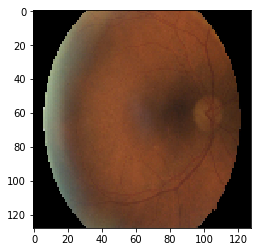

In [22]:
plt.imshow(x_train[10011]/255)
plt.show()

Its important to split the whole dataset into training and validation dataset apart from testing dataset which we have seperately.

In [23]:
x_valid = []
y_valid = []

In [24]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

Now we will define the model >>
The model has 2 convolutional leyers, 2 max pooling layes, image flattening layer and a dence layer
Models in Keras/TF come in 2 forms - Sequential (model = Sequential()) or using Funtional API
Below code is using Funtional API which is usually used for complex models, i will leave the light weight Sequential() model in comments

In [25]:
y_train_raw = np.array(Y_train)

In [26]:
x_train_raw = np.array(X_train)

In [43]:
visible = Input(shape=(128,128,3))
conv6 = Conv2D(16, kernel_size=(12,12), activation='relu', padding='valid')(visible)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)
#bat1 = BatchNormalization(axis = 1)(pool1)

conv2 = Conv2D(64, kernel_size=(8,8), activation='relu', padding='valid')(pool3)
conv3 = Conv2D(64, kernel_size=(4,4), activation='relu', padding='valid')(conv2)
conv4 = Conv2D(128, kernel_size=(4,4), activation='relu', padding='valid')(conv3)
conv5 = Conv2D(256, kernel_size=(4,4), activation='relu', padding='valid')(conv4)

pool2 = MaxPooling2D(pool_size=(2, 2))(conv5)
#pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool2)
hidden1 = Dense(128, activation='relu')(flat)
drop1 = Dropout(0.2)(hidden1)

hidden2 = Dense(64, activation='relu')(drop1)
drop2 = Dropout(0.2)(hidden2)
output = Dense(5, activation='sigmoid')(drop2)
#output = Dense(1, activation='sigmoid')(flat)
model = Model(inputs=visible, outputs=output)

If you are planning to run less complex model run below lines, i will suggess to use a trasfer learning technique if you are planning to use below model for better results

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(786, 786, 3)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

There are variety of optimizers available >> https://keras.io/optimizers/
More about loss functions >> https://keras.io/losses/
Metrics >> https://keras.io/metrics/

In [44]:
from keras import optimizers
opt = optimizers.adam(lr=0.001, decay=0.0)

In [45]:
model.compile(optimizer= opt, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Lets convert the array into a numpy array, this might take some time

This is how the layers are stack on top of each other

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 117, 117, 16)      6928      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 58, 58, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 51, 51, 64)        65600     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 48, 64)        65600     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 45, 45, 128)       131200    
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 42, 42, 256)       524544    
__________

This command will actually train the model.
Even with less number of images, you might come accross 'Insufficient memory error' or 'Kernel restart error'

In [47]:
with tf.device('/device:GPU:0'):    
    model.fit(x_train_raw, y_train_raw, batch_size=128, epochs=5, verbose=1)

Epoch 1/5
15166/15166 [==============================] - 61s 4ms/step - loss: 4.2956 - acc: 0.7084
Epoch 2/5
15166/15166 [==============================] - 57s 4ms/step - loss: 4.7102 - acc: 0.6969
Epoch 3/5
15166/15166 [==============================] - 57s 4ms/step - loss: 4.8894 - acc: 0.6868
Epoch 4/5
15166/15166 [==============================] - 57s 4ms/step - loss: 4.8836 - acc: 0.6877
Epoch 5/5
15166/15166 [==============================] - 58s 4ms/step - loss: 4.9612 - acc: 0.6825


In [29]:
x_valid_raw = np.array(X_valid)

In [30]:
y_valid_raw = np.array(Y_valid)

Once the model is trained, we need to evaluate the performance of the model with all validation dataset.

In [31]:
test_loss, test_acc = model.evaluate(x_valid_raw, y_valid_raw)

169/169 [==============================] - 0s 2ms/step


In [32]:
test_loss

2.338465699077358

In [33]:
test_acc

0.739644971824962

In [1]:
import tensorflow as tf
if tf.test.gpu_device_name():
     print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
     print("Please install GPU version of TF")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Default GPU Device: /device:GPU:0
